In [1]:
#import文
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
#DataFrameを作成
df_train=pd.read_csv('../main/data/train.csv')
df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,56,1,ASY,155,342,1,Normal,150,1,3.0,Flat,1
1,55,0,ATA,130,394,0,LVH,150,0,0.0,Up,0
2,47,1,NAP,110,0,1,Normal,120,1,0.0,Flat,1
3,34,1,ASY,115,0,1,Normal,154,0,0.2,Up,1
4,54,0,NAP,160,201,0,Normal,163,0,0.0,Up,0


In [4]:
#特徴量作成
df_train['H_risk']='Risk0'
for i in range(len(df_train)):
    if abs(df_train.loc[i,'Oldpeak'])<0.3 and df_train.loc[i,'ST_Slope']!='Up':
        df_train.loc[i,'H_risk']='Risk2'
    elif 0.3<=abs(df_train.loc[i,'Oldpeak'])<2.5 and df_train.loc[i,'ST_Slope']=='Up':
        df_train.loc[i,'H_risk']='Risk1'
    elif 0.3<=abs(df_train.loc[i,'Oldpeak'])<2.5 and df_train.loc[i,'ST_Slope']!='Up':
        df_train.loc[i,'H_risk']='Risk3'
    elif abs(df_train.loc[i,'Oldpeak'])>=2.5:
        df_train.loc[i,'H_risk']='Risk4'
    else:
        pass
df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,H_risk
0,56,1,ASY,155,342,1,Normal,150,1,3.0,Flat,1,Risk4
1,55,0,ATA,130,394,0,LVH,150,0,0.0,Up,0,Risk0
2,47,1,NAP,110,0,1,Normal,120,1,0.0,Flat,1,Risk2
3,34,1,ASY,115,0,1,Normal,154,0,0.2,Up,1,Risk0
4,54,0,NAP,160,201,0,Normal,163,0,0.0,Up,0,Risk0


In [5]:
##cholesterolの特徴量作成:CholCat
df_train['CholCat']='chol0'
for i in range(len(df_train)):
    if 200>df_train.loc[i,'Cholesterol']>0:
        df_train.loc[i,'CholCat']='chol1'
    elif 320>df_train.loc[i,'Cholesterol']>=200:
        df_train.loc[i,'CholCat']='chol2'
    elif df_train.loc[i,'Cholesterol']>=320:
        df_train.loc[i,'CholCat']='chol3'
    else:
        pass
df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,H_risk,CholCat
0,56,1,ASY,155,342,1,Normal,150,1,3.0,Flat,1,Risk4,chol3
1,55,0,ATA,130,394,0,LVH,150,0,0.0,Up,0,Risk0,chol3
2,47,1,NAP,110,0,1,Normal,120,1,0.0,Flat,1,Risk2,chol0
3,34,1,ASY,115,0,1,Normal,154,0,0.2,Up,1,Risk0,chol0
4,54,0,NAP,160,201,0,Normal,163,0,0.0,Up,0,Risk0,chol2


In [6]:
#その他の特徴量の前処理

#ChestPainTypeを特徴量に入れる場合以下を実行

#TAとATAをTA+ATAとする(分布が似ているかつカテゴリー中のデータ数が少ないため)
df_train.loc[df_train['ChestPainType']=='TA','ChestPainType']='TA+ATA'
df_train.loc[df_train['ChestPainType']=='ATA','ChestPainType']='TA+ATA'
df_train['ChestPainType'].unique()



#OneHotencoder(必要な分だけ)
#ChestPainType,RestingECG,ST_SlopをOneHotEncoding
df_train=df_train.join(pd.get_dummies(df_train['ChestPainType']))
df_train=df_train.join(pd.get_dummies(df_train['RestingECG']))
df_train=df_train.join(pd.get_dummies(df_train['CholCat']))
df_train=df_train.join(pd.get_dummies(df_train['H_risk']))

#特徴量に使用する連続値のデータを標準化
#データ標準化する対象を選択
numeric_features=['Age','RestingBP', 'MaxHR']

#標準化したデータを元のデータに入れる
#_zで標準化したデータに対応
SS=StandardScaler()
df_train[['Age_z','RestingBP_z','MaxHR_z']]=SS.fit_transform(df_train[numeric_features].values)

df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,...,chol2,chol3,Risk0,Risk1,Risk2,Risk3,Risk4,Age_z,RestingBP_z,MaxHR_z
0,56,1,ASY,155,342,1,Normal,150,1,3.0,...,0,1,0,0,0,0,1,0.256306,1.272672,0.512265
1,55,0,TA+ATA,130,394,0,LVH,150,0,0.0,...,0,1,1,0,0,0,0,0.151431,-0.116784,0.512265
2,47,1,NAP,110,0,1,Normal,120,1,0.0,...,0,0,0,0,1,0,0,-0.687567,-1.228348,-0.706992
3,34,1,ASY,115,0,1,Normal,154,0,0.2,...,0,0,1,0,0,0,0,-2.050938,-0.950457,0.674833
4,54,0,NAP,160,201,0,Normal,163,0,0.0,...,1,0,1,0,0,0,0,0.046557,1.550563,1.040610


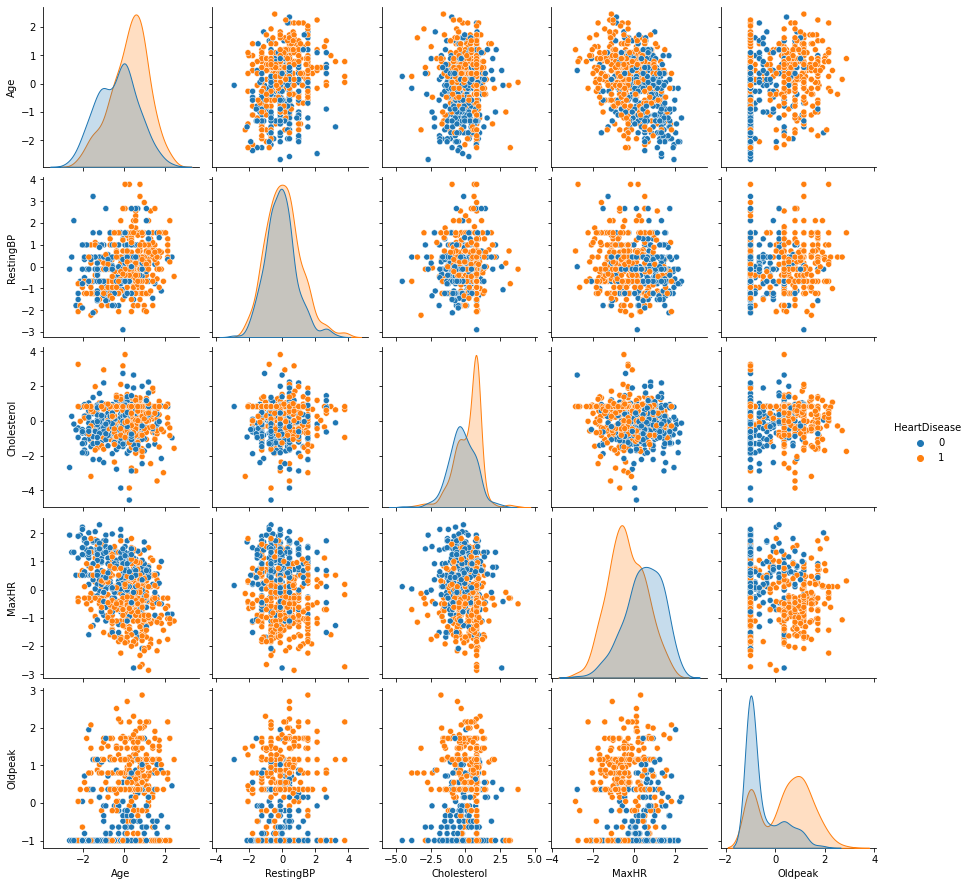

In [456]:
sns.pairplot(df_train,vars=numeric_features,hue='HeartDisease')
plt.show()

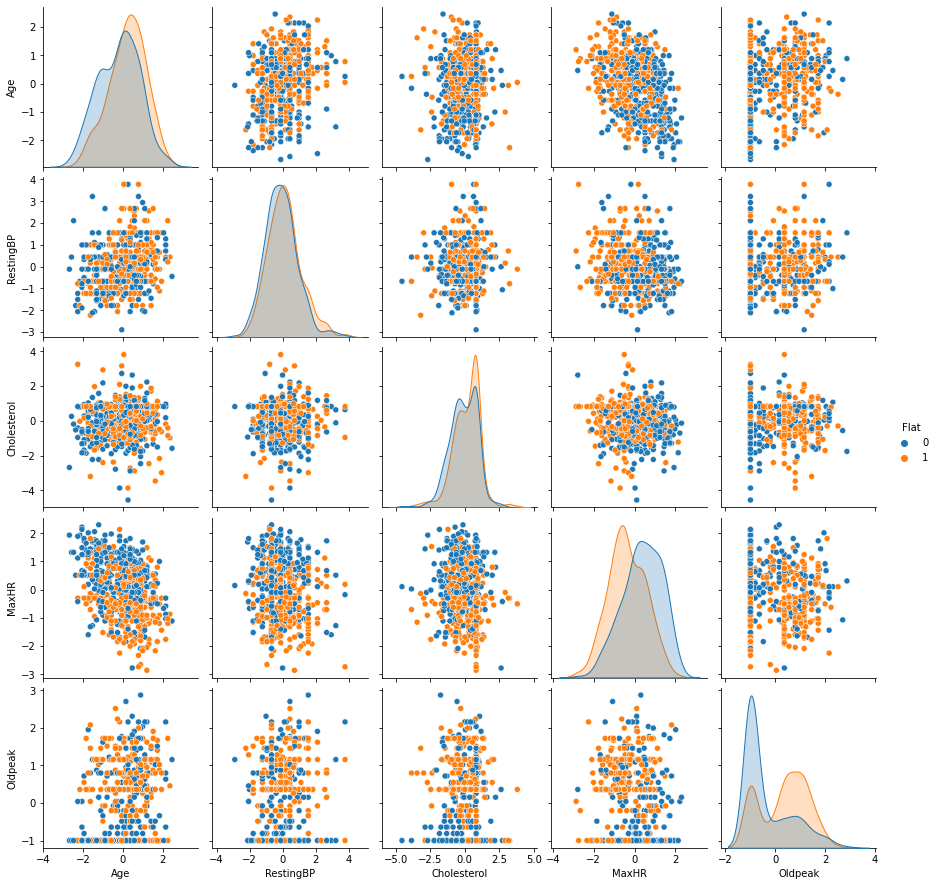

In [346]:
sns.pairplot(df_train,vars=numeric_features,hue='Flat')
plt.show()

In [15]:
#tensorへの変換練習
X_array=df_train[['Sex','FastingBS','FastingBS','ExerciseAngina','ASY', 'NAP', 'TA+ATA', 'LVH','Normal','ST','chol0', 'chol1', 'chol2', 'chol3', 'Risk0', 'Risk1','Risk2', 'Risk3', 'Risk4', 'Age_z', 'RestingBP_z', 'MaxHR_z']].values
y_array=pd.get_dummies(df_train['HeartDisease']).values



#データ分割
X_train_arr,X_test_arr,y_train_arr,y_test_arr=train_test_split(X_array,y_array,random_state=3,test_size=0.2)



#テンソルに変換
X_train_tf = tf.multiply(X_train_arr, 1)
X_test_tf = tf.multiply(X_test_arr,1)
y_train_tf = tf.multiply(y_train_arr,1)
y_test_tf = tf.multiply(y_test_arr,1)

In [16]:
X_array[1,:]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.15143128,
       -0.11678351,  0.5122651 ])

In [8]:
df_train.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease', 'H_risk', 'CholCat', 'ASY', 'NAP', 'TA+ATA', 'LVH',
       'Normal', 'ST', 'chol0', 'chol1', 'chol2', 'chol3', 'Risk0', 'Risk1',
       'Risk2', 'Risk3', 'Risk4', 'Age_z', 'RestingBP_z', 'MaxHR_z'],
      dtype='object')

In [17]:
y_test_tf.shape

TensorShape([129, 2])

In [35]:
#データ分割
#X_train,X_test,y_train,y_test=train_test_split(df_train.drop(columns='HeartDisease'),df_train['HeartDisease'],random_state=1,test_size=0.2)

In [19]:
#TensorflowによるCNNモデル作成

#モデルの定義
def get_new_model(input_shape):
    ini = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.2,seed=5)
    model = Sequential([
        Dense(16,activation='selu',kernel_initializer=ini,bias_initializer=ini),
        LayerNormalization(),
        Dropout(0.5),
        Dense(16,activation ='relu',kernel_initializer=ini,bias_initializer=ini),
        Dropout(0.5),
        Dense(16,activation ='relu',kernel_initializer=ini,bias_initializer=ini),
        Dense(2,activation = 'sigmoid',kernel_initializer=ini,bias_initializer=ini)
    ])
    return model




In [20]:
model=get_new_model(X_train_tf.shape)
model.build(input_shape=X_train_tf.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (513, 16)                 368       
                                                                 
 layer_normalization (LayerN  (513, 16)                32        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (513, 16)                 0         
                                                                 
 dense_1 (Dense)             (513, 16)                 272       
                                                                 
 dropout_1 (Dropout)         (513, 16)                 0         
                                                                 
 dense_2 (Dense)             (513, 16)                 272       
                                                        

In [21]:
#コンパイラーの定義：lossは2値分類なのでcategorical crossentropyで問題無いはず
def compile_model(model):
    model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
compile_model(model)

In [34]:
#epoch毎の結果でベストのもののみ取ってくる
def get_best_epoch():
    checkpoint_every_epoch_path= "model_best_checkpoints/MLP"
    checkpoint_every_epoch=ModelCheckpoint(filepath=checkpoint_every_epoch_path,
                                           save_weights_only=False,
                                           save_freq="epoch",
                                           monitor="loss", #val_loss
                                           save_best_only=True,
                                           verbose=1)
    return checkpoint_every_epoch

#early_stoppingの定義
def get_early_stopping():
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss",mode='min',patience=3) #val_loss
    return early_stopping

In [35]:
#関数をインスタンス化？
cp1 = get_best_epoch()
cp2 = get_early_stopping()




#学習の定義
def train_model(x_train,y_train,epochs):
    
    history = model.fit(x=x_train,y=y_train,epochs=epochs,batch_size=30,callbacks=[cp1,cp2],validation_split=0.2)
    return history

In [36]:
history = train_model(X_train_tf,y_train_tf,20)

Epoch 1/20
12/14 [========================>.....] - ETA: 0s - loss: 0.3608 - accuracy: 0.8694
Epoch 1: loss improved from inf to 0.36252, saving model to model_best_checkpoints\MLP
INFO:tensorflow:Assets written to: model_best_checkpoints\MLP\assets
14/14 [==============================] - 3s 250ms/step - loss: 0.3625 - accuracy: 0.8732 - val_loss: 0.2292 - val_accuracy: 0.9223
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.8707
Epoch 2: loss improved from 0.36252 to 0.32974, saving model to model_best_checkpoints\MLP
INFO:tensorflow:Assets written to: model_best_checkpoints\MLP\assets
14/14 [==============================] - 3s 241ms/step - loss: 0.3297 - accuracy: 0.8707 - val_loss: 0.2292 - val_accuracy: 0.9223
Epoch 3/20
13/14 [==========================>...] - ETA: 0s - loss: 0.4013 - accuracy: 0.8590
Epoch 3: loss did not improve from 0.32974
14/14 [==============================] - 0s 10ms/step - loss: 0.3901 - accuracy: 0.8659 - val_los

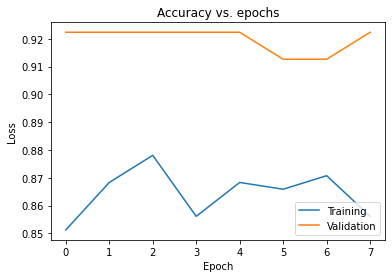

In [31]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

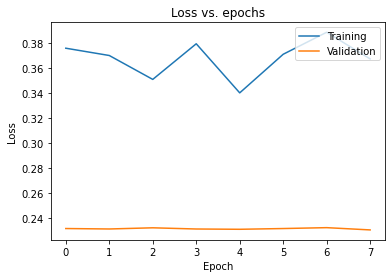

In [32]:
#Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [37]:
def get_accuracy(x_test,y_test,model):
  loss,acc = model.evaluate(x=x_test,y=y_test,verbose=0)
  print("loss:{loss:0.3f}  accuracy:{acc:0.3f}".format(loss=loss,acc=acc))

get_accuracy(X_test_tf,y_test_tf,model)

loss:0.388  accuracy:0.837


In [508]:
tf.multiply(df_train.drop(columns='HeartDisease').values,1).shape
df_train.columns

Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'HeartDisease', 'chol0', 'ASY', 'NAP',
       'LVH', 'ST', 'Down', 'Flat', 'Up'],
      dtype='object')

In [511]:
y_pred=model.predict(tf.multiply(df_train.drop(columns=['HeartDisease','Cholesterol']).values,1))

21/21 [==============================] - 0s 4ms/step


In [512]:
df_train['pred']=0
for i in range(len(y_pred)):
    if y_pred[i,1]>y_pred[i,0]:
        df_train.loc[i,'pred']=1
    else:
        pass


In [513]:
df_train['ACC']=0
for i in range(len(df_train)):
    if df_train.loc[i,'HeartDisease']==df_train.loc[i,'pred']:
        df_train.loc[i,'ACC']=1
    else:
        pass


In [514]:
df_train

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,chol0,ASY,NAP,LVH,ST,Down,Flat,Up,pred,ACC
0,0.256306,1,1.272672,1.378667,1,0.512265,1,1.719987,1,0,1,0,0,0,0,1,0,1,1
1,0.151431,0,-0.116784,1.983491,0,0.512265,0,-0.996914,0,0,0,0,1,0,0,0,1,0,1
2,-0.687567,1,-1.228348,0.818983,1,-0.706992,1,-0.996914,1,1,0,1,0,0,0,1,0,1,1
3,-2.050938,1,-0.950457,0.818983,1,0.674833,0,-0.639595,1,1,1,0,0,0,0,0,1,1,1
4,0.046557,0,1.550563,-0.889983,0,1.040610,0,-0.996914,0,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,-0.582692,1,-1.450661,0.256982,1,-1.113411,0,-0.996914,1,0,1,0,0,0,0,1,0,1,1
638,-0.058318,1,-0.339096,0.818983,0,-1.275978,0,-0.996914,1,1,1,0,0,0,0,1,0,1,1
639,0.046557,1,3.773692,-0.954096,0,0.187130,1,1.156179,1,0,1,0,0,0,0,1,0,1,1
640,-0.897316,0,-0.116784,-0.187261,0,1.325103,0,-0.996914,0,0,0,0,0,0,0,0,1,0,1


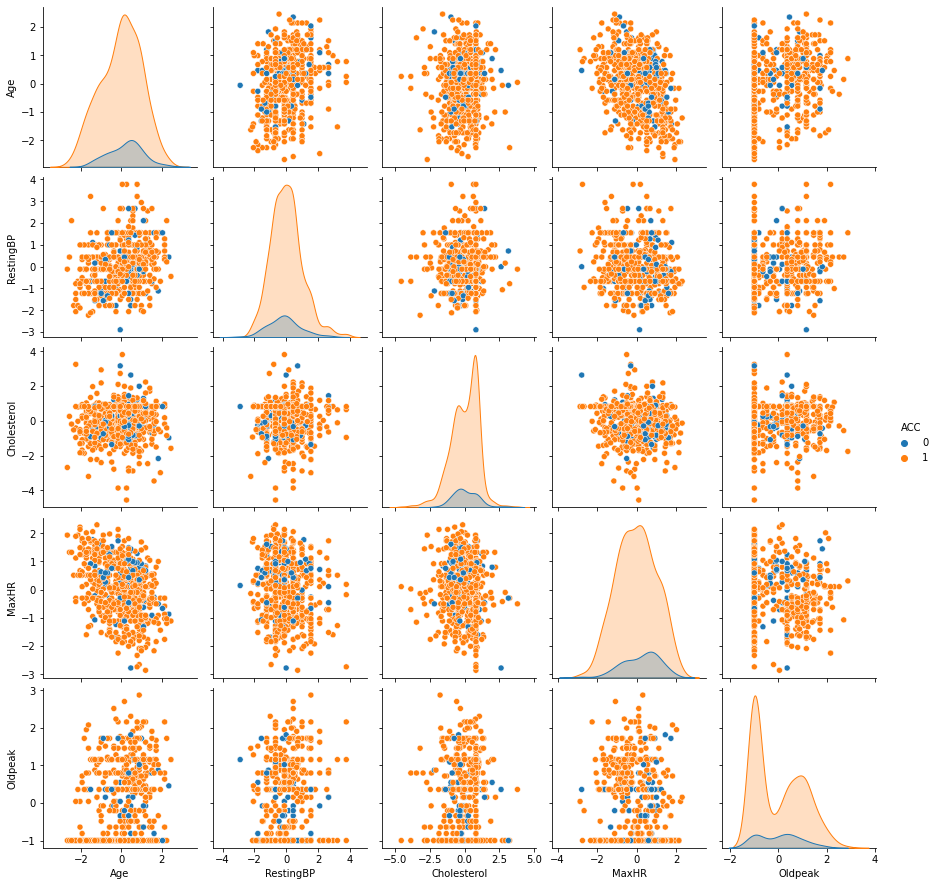

In [515]:
#ご分類のデータの分布を確認
sns.pairplot(df_train,vars=numeric_features,hue='ACC')
plt.show()

In [ ]:
#MaxHRで全体分布と間違いのある分布に肩よりがある→改善代?

In [516]:
pd.crosstab(df_train['HeartDisease'],df_train['ACC'])

ACC,0,1
HeartDisease,,
0,50,233
1,28,331


In [ ]:
#心臓病で無い人を心臓病と判断しがち

In [517]:
pd.crosstab(df_train['chol0'],df_train['ACC'])

ACC,0,1
chol0,,
0,68,451
1,10,113
